## 3.1 Software Requirements

In [1]:
import pandas as pd # Data handling
import geopandas as geopd # Handling shapefile
import matplotlib.pyplot as plt # Generating plots

In addition to these modules, you will likely need to install `descartes` module by `pip install descartes` to use geometric objects with matplotlib.

## 3.2 How to Handle Shapefiles

To handle shapefiles in python, you can use a library called `geopandas`. `read_file()` function of this library reads a shapefile as a `GeoDataFrame` object which is a `pandas.DataFrame` with a geometry column containing vector information.

Operations such as deleting rows and merging with other data frames are the same as for `pandas.DataFrame`. Thus you can manipulate shapefiles just as easily as with normal data frames in pandas.

In [2]:
filename = "../maps/compiled/cb_2018_us_state_500k.shp"
sf_us = geopd.read_file(filename)

In [3]:
type(sf_us)

geopandas.geodataframe.GeoDataFrame

We can check what kind of CRS this object is using by `.crs` attribute.

In [4]:
sf_us.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

We can see that this object looks exactly like a `pandas.DataFrame` by printing. 

In [39]:
sf_us.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"POLYGON ((-91.16607 33.00411, -91.12464 33.064..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.62767 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00220 37.00010, -102.04209 36.9..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.64823 37.96677, -75.62434 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.59348 38.42182, -82.52958 38.405..."


`geometry` column itself is an object called `GeoSeries`. A `GeoDataFrame` can be thought of as a `DataFrame` that holds a `GeoSeries` inside.

## 3.3 How to Draw a US Map

We can easily draw state boundaries recorded as multi polygons in the `geometry` column using [`.plot()`](https://geopandas.org/reference.html#geopandas.GeoDataFrame.plot)

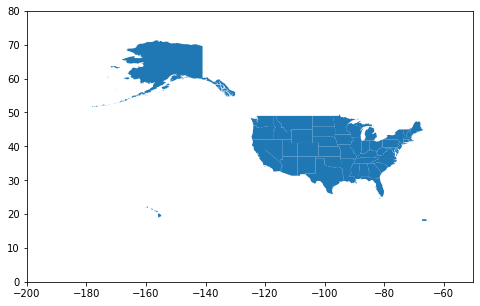

In [77]:
sf_us.plot(figsize=(8,6))
plt.xlim(-200, -50)
plt.ylim(0,80)
plt.savefig('../Python/results/whole_map_python.png',
           bbox_inches='tight', pad_inches=0.1)
plt.show()

The Census Bureau’s shapefiles also include coordinates for Alaska, Hawaii, or other distant territories, so they are not displayed at the scale we desire. The easiest solution is to drop the rows that contain these off-mainland states and territories.

In [7]:
dropstates = ["Alaska",
              "Hawaii",
              "Puerto Rico",
              "Guam",
              "United States Virgin Islands",
              "Commonwealth of the Northern Mariana Islands",
              "American Samoa"]

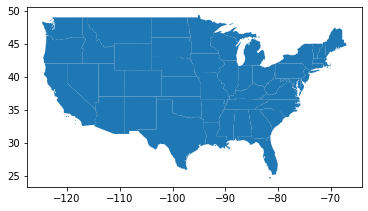

In [8]:
sf_us.query('NAME not in @dropstates').plot()
plt.savefig('../Python/results/dropped_map_python.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

However, we want to include Alaska and Hawaii because our purpose is to make a state-by-state comparison. Thus, as in the R example, we shrink and shift Alaska and Hawaii to be displayed closer to the mainland.

First, since Alaska is on the date line and divided into two pieces, we need to change the range of longitude from -180-180 to 0-360. Since there is no tool in python similar to the function `st_shift_longitude()` used in the R example (which transfers all coordinates below 0 to between 180-360), we need to create a custom CRS.

The simplest way to achieve this is to edit `proj.4` string. As introduced at the beginning of this tutorial, we can add options to the `proj.4` string. We will add `+lon_wrap=` option to the default NAD83 string in order to change the longitude to be wrapped.

The argument to `+lon_wrap=` is a center longitude. Thus, if we assign `+lon_wrap=180`, the entire coordinates will be shown between 0-360.

In [9]:
# default CRS of our data
nad83 = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"
# custom parameter
wrap = "+lon_wrap=180"
# change CRS of our GeoDataFrame
sf_us_360 = sf_us.to_crs(" ".join([nad83,wrap]))


Then we shift and scale Alaska and Hawaii. There are many [geometric manipulations available in geopandas](https://geopandas.org/geometric_manipulations.html), including affine transformation by a matrix A, and shift, scale, or rotate by a certain latitude and longitude value.

Note that these operations are available for `GeoSeries`, and that the resulting output is only the `geometry` column of the original `GeoDataFrame`. Therefore, after these operations, we need to overwrite the existing `geometry` column with the updated `GeoSeries`. This can be achieved by using `.set_geometry()` method of `GeoDataFrame`.

`.scale()` method returns scaled geometries. It allows us to specify not only the scaling factor in the x-y direction, but also the origin for the scaling operation. We specify `center = 'centroid'` here because we want to scale Alaska and Hawaii around their original place. The amount of shift in the direction of latitude and longitude is the same as the value determined by trial and error in our R example.

In [75]:
Alaska = sf_us_360.query('NAME == "Alaska"')
Alaska_geo = Alaska.scale(xfact=0.3, yfact=0.3,origin='centroid')\
                          .translate(xoff=36, yoff=-38)
Alaska = Alaska.set_geometry(Alaska_geo)

In [76]:
Hawaii = sf_us_360.query('NAME == "Hawaii"')
Hawaii_geo = Hawaii.scale(xfact=0.3, yfact=0.3,origin='centroid')\
                          .translate(xoff=53, yoff=5)
Hawaii = Hawaii.set_geometry(Hawaii_geo)

In [12]:
sf_us_shifted = geopd.GeoDataFrame(
    pd.concat(
        [sf_us_360.query('NAME not in @dropstates'),
         Alaska,
         Hawaii]))

*will insert an explanation about mercator and equal area projection*

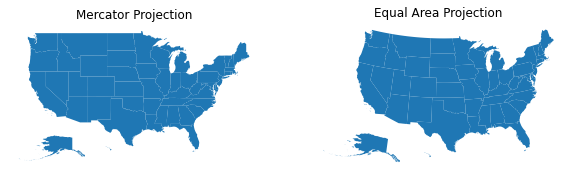

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
sf_us_shifted.to_crs("+proj=merc").plot(ax=ax1)
ax1.set_title("Mercator Projection")
ax1.axis('off')
sf_us_shifted.to_crs("+proj=aea +lat_1=25 +lat_2=50 +lon_0=-100").plot(ax=ax2)
ax2.set_title("Equal Area Projection")
ax2.axis('off')
plt.savefig('../Python/results/transformed_map_python.png', 
            bbox_inches='tight', pad_inches=0.1)
plt.show()

The final map we will use in the later sections is the one with Alaska and Hawaii, projected by Mercator CRS.

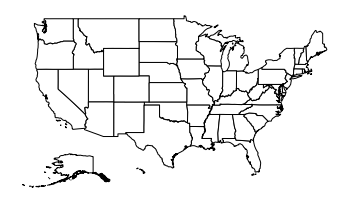

In [14]:
sf_us_shifted.to_crs("+proj=merc").plot(color="white", edgecolor='black')
plt.axis('off')
plt.savefig('../Python/results/final_map_python.png',
            bbox_inches='tight', pad_inches=0.1)
plt.show()

# 4 Prepare Count Data to Display

## 4.1 Software Requirements

In [58]:
import pandas as pd# Data handling

## 4.2 Merge COVID-19 Count with Geographic Data

In [59]:
# read data
all_data=pd.read_csv("../covid_fix_date/20201111-all-states-history.csv")

# Select variables
df_covid=all_data[['date','state','positiveIncrease']]

# delete territories
df_covid=df_covid[~df_covid['state'].isin(["AS", "GU", "MP", "PR", "VI"])]
df_covid["date"]=pd.to_datetime(df_covid["date"])

In [62]:
# Aggregate by State and Quarter
df_covid1=df_covid.set_index('date')
df_state_q= df_covid1.groupby('state')['positiveIncrease']\
                     .resample("Q").sum().unstack()
df_state_q.reset_index(inplace=True)

# rename columns
df_state_q.columns=['state','2020.1','2020.2','2020.3','2020.4']
sf_us_shifted.rename(columns={"STUSPS":"state"},inplace=True)

In [18]:
# Store maximum value for consistent plots for all quarters
max_positive = pd.DataFrame(df_state_q.max())\
                            .drop(['state'],axis=0).astype('int').max()

In [19]:
# Merge with sf object
sf_merge=pd.merge(sf_us_shifted,df_state_q)

In [57]:
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 1000) 
# pd.set_option('expand_frame_repr', False)

In [56]:
# only left related columns
sf_merge=sf_merge.iloc[:,[4,5,9,10,11,12,13]]
sf_merge.head()

,state,NAME,geometry,2020.1,2020.2,2020.3,2020.4
0,MS,Mississippi,"POLYGON ((268.834 33.004, 268.875 33.064, 268....",937,26310,70943,31204
1,NC,North Carolina,"MULTIPOLYGON (((284.273 35.936, 284.372 35.883...",1497,63172,145962,89929
2,OK,Oklahoma,"POLYGON ((256.998 37.000, 257.958 36.993, 259....",564,13192,73442,55135
3,VA,Virginia,"MULTIPOLYGON (((284.352 37.967, 284.376 37.994...",1250,61537,85484,48235
4,WV,West Virginia,"POLYGON ((277.407 38.422, 277.470 38.405, 277....",162,2743,12943,14353


# 5 Generate Choropleth Maps

## 5.1 Software Requirements

In [63]:
import pandas as pd # Data handling
import geopandas as geopd # Handling shapefile
import matplotlib.pyplot as plt # Generating plots

In [64]:
# define function to plot and save figures
def draw_map_quarter(sf_obj, target_q,maxlim):
    fig, ax = plt.subplots(figsize=(20, 10))
    sf_obj.to_crs("+proj=merc").plot(column=target_q, cmap='Reds',ax=ax, 
                                     legend=True,edgecolor='w',
                                     legend_kwds={'label': 'Counts'},
                                     vmin=0, vmax=maxlim)
    # set title
    plt.title(str(target_q[0:4])+"Q"+str(target_q[-1])
              +"- Total COVID-19 Cases",
              fontsize=15)
    # Hide axis
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.axis('off')
    name=str(target_q[0:4])+"Q"+str(target_q[-1])+'.png'
    plt.savefig("../Python/results/{}".format(name))
    plt.show()
    return

## 5.2 Show Choropleth Maps for each Quarter in 2020

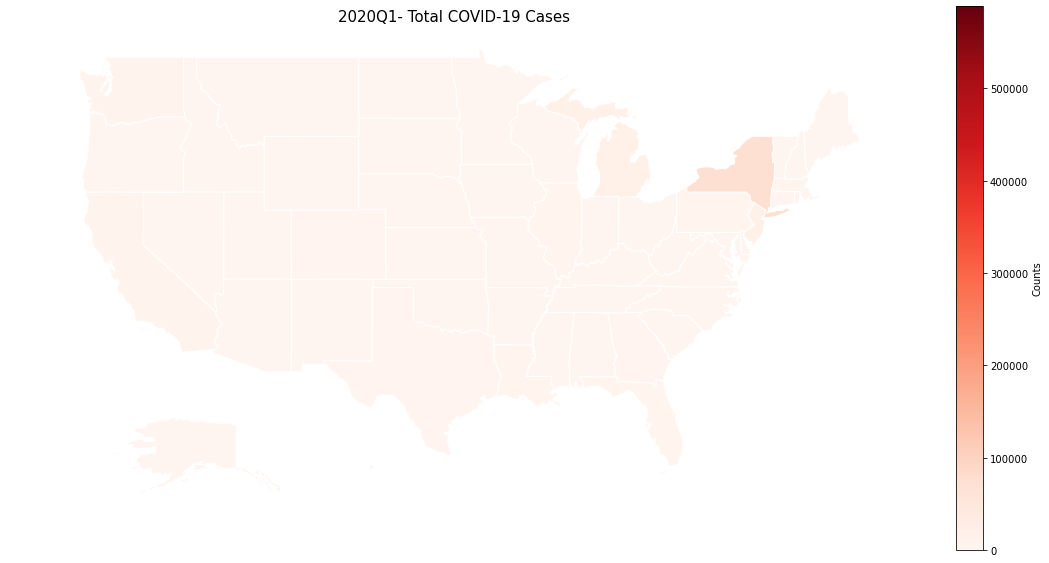

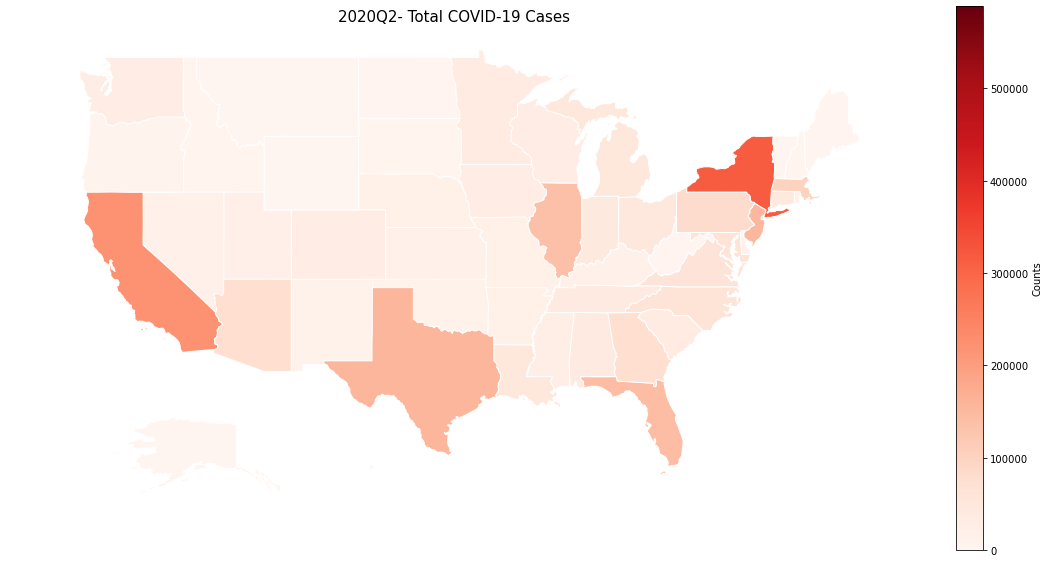

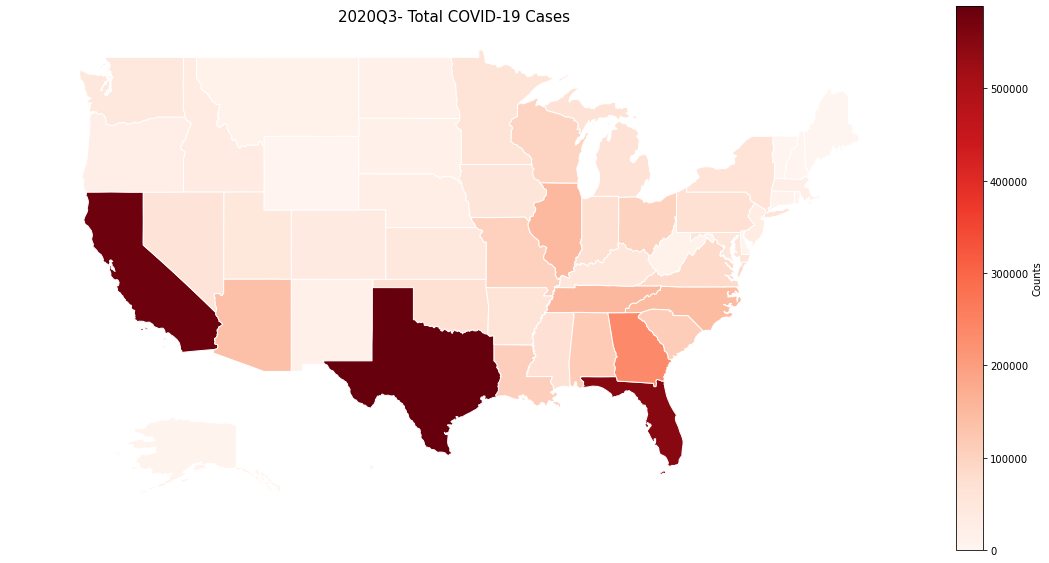

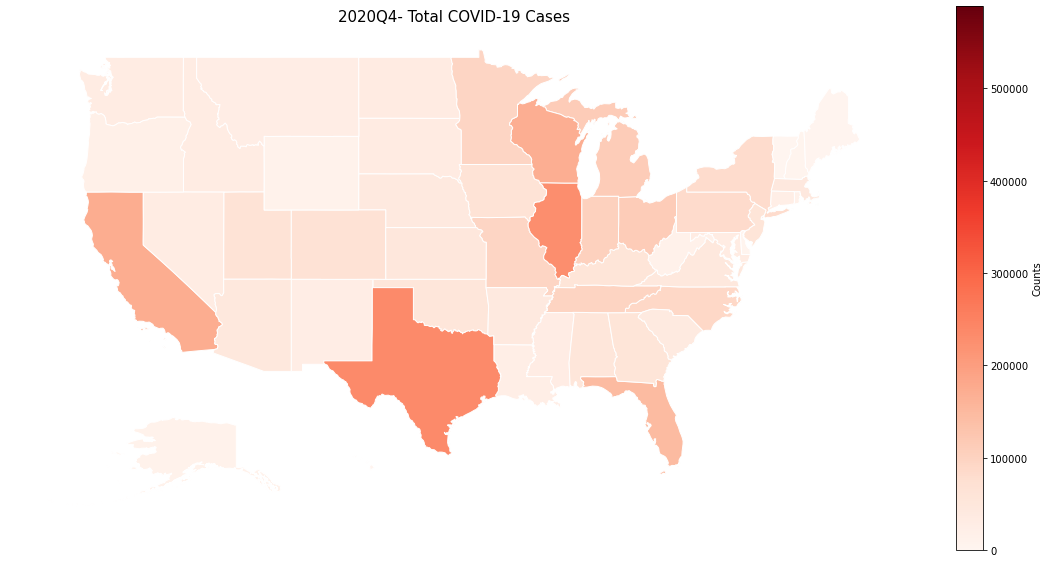

In [65]:
draw_map_quarter(sf_merge, "2020.1",max_positive)
draw_map_quarter(sf_merge, "2020.2",max_positive)
draw_map_quarter(sf_merge, "2020.3",max_positive)
draw_map_quarter(sf_merge, "2020.4",max_positive)

# 6 Extended Example: Interactive Choropleth Maps

## 6.1 Software Requirements

In [66]:
import pandas as pd # Data handling
import geopandas as geopd # Handling shapefile
import plotly.express as px # Generating plots

## 6.2 Generate Interactive/Animated Choropleth Map

In [74]:
# Aggregate by State and Month
df_covid2=df_covid.set_index('date')
df_state_m= df_covid2.groupby('state')['positiveIncrease']\
            .resample("M").sum().unstack()
df_state_m.reset_index(inplace=True)
col_name=list(df_state_m.columns[1:].map(lambda x: x.strftime('%Y-%m')))
col_name=['state',col_name]

# Unlock the nesting level of col_name and assign it to the new column name
df_state_m.columns= eval('[%s]'%repr(col_name)\
                         .replace('[', '').replace(']', ''))
df_state_m=df_state_m.fillna(0)

In [68]:
# transfrom wide table to long table
df_state_m=df_state_m.melt(
    id_vars=["state"],
    var_name="Month",
    value_name="total_pos"
)

In [69]:
# Merge with sf object
sf_merge_m=pd.merge(sf_us_shifted,df_state_m)

In [70]:
# only left related columns
sf_merge_m = sf_merge_m.iloc[:, [10, 4, 5, 9, -1]]
sf_merge_m.head()

,Month,state,NAME,geometry,total_pos
0,2020-01,MS,Mississippi,"POLYGON ((268.834 33.004, 268.875 33.064, 268....",0.0
1,2020-02,MS,Mississippi,"POLYGON ((268.834 33.004, 268.875 33.064, 268....",0.0
2,2020-03,MS,Mississippi,"POLYGON ((268.834 33.004, 268.875 33.064, 268....",937.0
3,2020-04,MS,Mississippi,"POLYGON ((268.834 33.004, 268.875 33.064, 268....",5878.0
4,2020-05,MS,Mississippi,"POLYGON ((268.834 33.004, 268.875 33.064, 268....",8686.0


In [71]:
# prepare shift map for Interactive Choropleth Maps

Alaska2 = sf_us.query('NAME == "Alaska"')
Alaska_geo2= Alaska2.scale(xfact=0.3, yfact=0.3, origin='centroid')\
                           .translate(xoff=36, yoff=-38)


Alaska2 = Alaska2.set_geometry(Alaska_geo2)

Hawaii2 = sf_us.query('NAME == "Hawaii"')
Hawaii_geo2 = Hawaii2.scale(xfact=0.3, yfact=0.3, origin='centroid')\
                            .translate(xoff=53, yoff=5)
Hawaii2 = Hawaii2.set_geometry(Hawaii_geo2)
sf_us_shifted2 = geopd.GeoDataFrame(
    pd.concat(
        [sf_us.query('NAME not in @dropstates'),
         Alaska2,
         Hawaii2]))
sf_us_shifted2.rename(columns={"STUSPS":"state"},inplace=True)

# creat a column for hover text
sf_merge_m['text'] = "Positives in" + " " + sf_merge_m['NAME'] + " " + \
                     sf_merge_m['total_pos'].map(lambda x: str(int(x)))
sf_merge_m_03_11 = sf_merge_m.query('Month != "2020-01" & Month != "2020-02"')

In [73]:
config = {
    'displaylogo': False,
    'editable': True,
    'responsive': False,
    'displayModeBar': False
}

# plotting
fig = px.choropleth_mapbox(
    data_frame=sf_merge_m_03_11,
    geojson=sf_us_shifted2,
    locations="state",
    featureidkey="properties.state",    
    mapbox_style="white-bg",
    color_continuous_scale='reds',
    color='total_pos',
    labels={'total_pos':'Counts'},
    range_color=[0, 330000],
    hover_name=sf_merge_m_03_11["text"],
    hover_data={'text':False,
                'Month':True,
                'state':False,
                'total_pos':False},               
    center = {"lat": 37.0902, "lon": -95.7129},
    zoom=2,
    animation_frame='Month',
    width=800,
    height=480
    )
fig.update_layout( title_text = 'USA Monthly COVID-19 Cases',
                   title_x = 0.5, geo=dict( showframe = False,
                                            showcoastlines = False))
fig.write_html('../Python/results/Month_case.html', config=config)